Testing CNN method from https://wandb.ai/mostafaibrahim17/ml-articles/reports/An-Introduction-to-Audio-Classification-with-Keras--Vmlldzo0MDQzNDUy#:~:text=%EF%BB%BFKeras%20is%20a%20go,both%20beginners%20and%20advanced%20users.

https://keras.io/guides/sequential_model/

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras import layers # example functions: Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D
from keras import Input
import matplotlib.pyplot as plt
import time

In [17]:
%run FeedingData.ipynb
# read Calvin's function files so we can call those functions from this notebook
# list of functions: 
# mfcc_(song, n=20)
# mfcc_cut(song, n=20, cutoff = 800)
# LFCC(song, n=20)
# LFCC_no_low(song, n=20, cutoff = 800)
# LFCC_no_low_clean(song, n=20, cutoff = 800)
# mfcc_cut_cleaned(song, n=20, cutoff = 800)
# main_freq(song, cutoff = 800)

In [24]:
song, sr = librosa.load('E:\chirpfiles\\no_voice_files\\82069.wav')
a = mfcc_(song)
a.shape

(20, 8)

In [36]:
def get_data(audio_path, meta_file, label_name, load_length, get_feature_function):
    songs_matrix = []
    songs_label = []
    audio_list = os.listdir(audio_path)
    df = pd.read_csv(meta_file)

    for name in audio_list:
        # parse out number part of the data files so we can get the corresponding label from meta_file
        number = name.replace('_', '.').split('.')[0]
        filepath = os.path.join(audio_path, name)
        # skipping files that are less than 250KB ~ 5sec long
        # this is to make sure we have enough length for sampling fft time intervals
        if os.path.getsize(filepath) < load_length*50000:
            continue
        # ============ load the data and get matrix ============
        # replace this block with function that cleansup data and outputs a feature matrix per file
        # make sure that the size of the feature matrix is the same for all files
        # name the output feature matrix mfccs 
        song, sr = librosa.load(filepath, duration=load_length)
        features = get_feature_function(song, n = 40)
        ##librosa.feature.mfcc(y = song, n_mfcc = 40)#, n_fft=512) # width of this matrix is file size in kb

        #mfcc = np.mean(mfccs, axis=1) # average over columns, shape(n_mfcc, ), used for vector input data
        # ======================================================
        songs_matrix.append(features)
        songs_label.append(df[label_name].loc[df.cat_num == float(number)].item())
    return np.array(songs_matrix), np.array(songs_label)

In [73]:
# for converting strings of label from one division to another, e.g. fam/subfam to critter name
def convert_labels(labels, meta_file, from_division, to_division):
    # find label in labels in meta_file under column from_division
    # append as key in dictionary lookup_table
    # append as value the correspondign label in to_division

    df = pd.read_csv(meta_file, usecols=[from_division, to_division])
    lookup_table = dict() # look up table for new label
    for label in labels:
        if label in lookup_table.keys():
            continue
        idx = df.loc[df[from_division]==label].index[0]
        lookup_table[label] = df[to_division][idx]
    return [lookup_table[label] for label in labels]

# example testing block
#from_division = 'fam_or_subfam'
#to_division = 'critter_name'
#meta_file = 'MLNS_Insects_Fams_05212024.csv'
#labels = ['Acrididae', 'Cicadidae', 'Acrididae', 'Listroscelidinae', 
#                  'Mogoplistinae', 'Nemobiinae', 'Oecanthinae', 'Phalangopsidae',
#                  'Phaneropterinae', 'Oecanthinae', 'Tettigoniinae','Trigonidiinae']    
#convert_labels(labels, meta_file, from_division, to_division)

In [55]:
# load all audio in audio_path
# convert to matrix, save in np array, 
# load the corresponding label_name from lable_filename, save in another np array

audio_path = 'E:\chirpfiles\\selected_files'
meta_file = 'MLNS_Insects_Fams_05212024.csv'
label_name = 'fam_or_subfam'
start = time.time()
max_time = 10 # cut off time for loading, in sec
get_feature_function = mfcc_
songs_matrix, songs_label = get_data(audio_path, meta_file, label_name, max_time, get_feature_function)
end = time.time()
print('time loading:', end - start)

time loading: 1.6596055030822754


In [58]:
#print(songs_matrix.shape)
df_class = pd.DataFrame(np.unique(songs_label, return_counts=True)).T
print('Data read:\n', df_class)

# remove classes with too few data points
small_class_list = []
for row in range(len(df_class)):
    if df_class[1].iloc[row] < 10:
        small_class_list.append(df_class[0].iloc[row].item())
print('Removing classes:\n',small_class_list)

delete_list = []
for small_class in small_class_list:
    delete_list += list(np.where(songs_label==small_class)[0])

short_label = np.delete(songs_label, delete_list)
short_matrix = np.delete(songs_matrix, delete_list, 0)
# double check data after deleting
print('Reduced data:\n', pd.DataFrame(np.unique(short_label, return_counts=True)).T)

Data read:
                  0   1
0        Cicadidae   8
1   Conocephalinae  18
2        Gryllinae  12
3       Hapithinae   2
4       Nemobiinae   6
5      Oecanthinae  23
6  Phaneropterinae   5
7  Pseudophyllinae   5
8    Tettigoniinae   5
9    Trigonidiinae   2
Removing classes:
 ['Cicadidae', 'Hapithinae', 'Nemobiinae', 'Phaneropterinae', 'Pseudophyllinae', 'Tettigoniinae', 'Trigonidiinae']
Reduced data:
                 0   1
0  Conocephalinae  18
1       Gryllinae  12
2     Oecanthinae  23


In [63]:
# convert insec fam into numbers. use le.inverse_transform to go from number to name
le = LabelEncoder()
songs_label_num = le.fit_transform(short_label)
songs_label_onehot = to_categorical(songs_label_num) # required output format by cnn

# rename data/label variable name so that we don't need to change them in the model block
data_matrix = short_matrix
data_label = songs_label_onehot

X_train, X_test, y_train, y_test = train_test_split(data_matrix, data_label, 
                                                    test_size = .2, random_state = 404)
# to use 2d convolution, keras model expects 4d input shape
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],X_train.shape[2],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],X_test.shape[2],1))
print('Train test split train shape: ', X_train.shape)

X_tt, X_val, y_tt, y_val = train_test_split(X_train, y_train, test_size = .2, random_state = 202)
print('Train validation split train shape: ', X_tt.shape)

Train test split train shape:  (42, 40, 431, 1)
Train validation split train shape:  (33, 40, 431, 1)


In [64]:
# make model 
input_shape =  (X_tt.shape[1], X_tt.shape[2],1,) # first dimension of train data is n_datapoints
model = Sequential() 
model.add(Input(input_shape))
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2), strides=2))
#model.add(layers.Dropout(0.2))
#model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
#model.add(layers.MaxPooling2D((2,2), strides=2))
#model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(le.classes_), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.summary()

In [65]:
# train model
start = time.time()
epochs = 10
history = model.fit(X_tt, y_tt, epochs=epochs, batch_size=64, validation_data=(X_val, y_val))
end = time.time()
print('time training: ', end - start)
#predicted_vector = model.predict(X_test)
#predicted_class_index = np.argmax(predicted_vector, axis=-1)
#le.inverse_transform(predicted_class_index)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1818 - loss: 21.0092 - val_accuracy: 0.4444 - val_loss: 950.4333
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.5758 - loss: 814.2920 - val_accuracy: 0.5556 - val_loss: 1439.1810
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.4242 - loss: 1473.0204 - val_accuracy: 0.5556 - val_loss: 1193.0864
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.4242 - loss: 1153.8772 - val_accuracy: 0.6667 - val_loss: 815.9402
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.8182 - loss: 665.6736 - val_accuracy: 0.3333 - val_loss: 979.4311
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.5152 - loss: 704.8398 - val_accuracy: 0.4444 - val_loss: 780.8024
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.5758 - loss: 535.8137 - val_accuracy: 0.6667 - val_loss: 509.9429
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.6970 - loss: 332.2083 - va

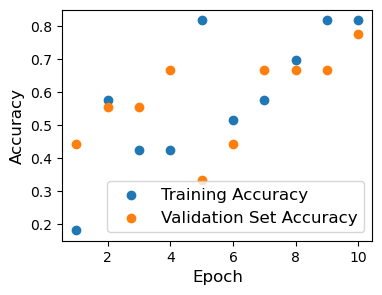

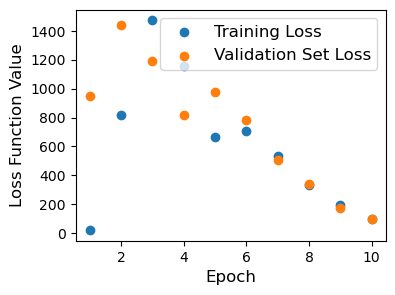

In [66]:
history_dict = history.history
plt.figure(figsize = (4, 3))
epochs = 10
plt.scatter(range(1,epochs+1), history_dict['accuracy'], label = "Training Accuracy")
plt.scatter(range(1,epochs+1), history_dict['val_accuracy'], label = "Validation Set Accuracy")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()

plt.figure(figsize = (4, 3))

plt.scatter(range(1,epochs+1), history_dict['loss'], label = "Training Loss")
plt.scatter(range(1,epochs+1), history_dict['val_loss'], label = "Validation Set Loss")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss Function Value", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()

# vvv
### Report accuracy on validation set 

In [67]:
predicted_vector = model.predict(X_val)
predicted_class_index = np.argmax(predicted_vector, axis=-1)
pred_class = le.inverse_transform(predicted_class_index)
true_class_idx = np.where(y_val.astype(int))[1]
true_class = le.inverse_transform(true_class_idx)
print(true_class)
conf_mat = confusion_matrix(true_class, pred_class)
print(pd.DataFrame(conf_mat))#,
#                 columns = ['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
#                 index = ['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])
accuracy = np.diagonal(conf_mat).sum()/np.sum(conf_mat)
print('accuracy =', accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
['Oecanthinae' 'Oecanthinae' 'Oecanthinae' 'Oecanthinae' 'Conocephalinae'
 'Gryllinae' 'Oecanthinae' 'Conocephalinae' 'Gryllinae']
   0  1  2
0  2  0  0
1  0  0  2
2  0  0  5
accuracy = 0.7777777777777778


In [74]:
## to shorte list of classes after fitting on long list, use the class converter. 
true_class_short = convert_labels(true_class, meta_file, label_name, 'critter_name')
pred_class_short = convert_labels(pred_class, meta_file, label_name, 'critter_name')
conf_mat = confusion_matrix(true_class_short, pred_class_short)
print(pd.DataFrame(conf_mat))
accuracy = np.diagonal(conf_mat).sum()/np.sum(conf_mat)
print('accuracy =', accuracy)

   0  1
0  7  0
1  0  2
accuracy = 1.0


# vvv 
### Forbidden test set block

In [88]:
predicted_vector = model.predict(X_test)
predicted_class_index = np.argmax(predicted_vector, axis=-1)

pred_class = le.inverse_transform(predicted_class_index)

true_class_idx = np.where(y_test.astype(int))[1]
true_class = le.inverse_transform(true_class_idx)
print(true_class)

conf_mat = confusion_matrix(true_class, pred_class)
print(pd.DataFrame(conf_mat))#,
#                 columns = ['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
#                 index = ['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])
accuracy = np.diagonal(conf_mat).sum()/np.sum(conf_mat)
print('accuracy =', accuracy)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [70]:
## to shorte list of classes after fitting on long list, use the class converter. 
true_class_short = convert_labels(true_class, meta_file, label_name, 'critter_name')
pred_class_short = convert_labels(pred_class, meta_file, label_name, 'critter_name')

conf_mat = confusion_matrix(true_class_short, pred_class_short)
print(pd.DataFrame(conf_mat))
accuracy = np.diagonal(conf_mat).sum()/np.sum(conf_mat)
print('accuracy =', accuracy)

NameError: name 'to_divison' is not defined